## 필요 툴&라이브러리 설치

In [ ]:
!pip install --upgrade pip
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib

## import

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import time

## Hyperpatemerers 등 configs 세팅

In [2]:
# 훈련 결과 재현을 위한 seed값 고정
seed = '202205281708'
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Hyperparameters
config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'mnist_mean': 0.1307,
    'mnist_std': 0.3081,
         }

## 모델 클래스 선언

In [3]:
class ModelV3(torch.nn.Module):
    def __init__(self):
        super(ModelV3, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## 인퍼런스 클래스 선언

In [4]:
class ModelV3Inferencer():
    def __init__(self, model, config):
        super(ModelV3Inferencer, self).__init__()
        self.device = config['device']
        self.mean = config['mnist_mean']
        self.std = config['mnist_std']
        self.model = model.to(self.device)
        self.model.eval()

    def load_and_preprocess_data(self, data_path):
        '''
        # 입력: [10, 28, 28] shape를 갖는 mnist_inputs.npy 파일 위치를 가리키는 string
        # 출력: [10, 1, 28, 28] shape를 갖는 torch.Tensor data
        '''
        # data를 np.array로 불러옴
        data = np.load(data_path)
        
        # data의 분포를 훈련 데이터 때의 분포와 동일하게 맞춰주기 위한 작업
        data = (data - self.mean) / self.std
        
        # data를 np.array에서 torch.tensor로 변환
        data = torch.from_numpy(data)
        
        # ModelV3는 [batch_size, channel, width, height] 4-Dimension 데이터를 입력받음
        # channel에 해당하는 차원을 뚫어줘야 함
        data = data.unsqueeze(1)
        
        return data
        
    def inference(self, data):
        '''
        # 입력: [N, 1, 28, 28] shape를 갖는 torch.Tensor data
        # 출력: [N] shape를 갖는 torch.Tensor data
        '''
        with torch.no_grad():
            # GPU를 사용 가능하다면 메모리를 이동
            data = data.to(self.device)
            
            # 인퍼런스 후 출력을 cpu 메모리로 옮김
            prob = self.model.forward(data)
            output = prob.argmax(dim=1, keepdim=False)
            return output.cpu()

## 인퍼런스 진행

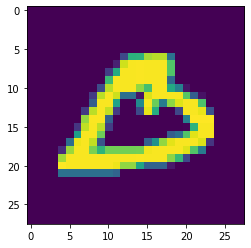

output: 0


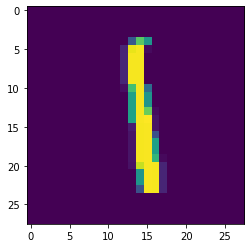

output: 1


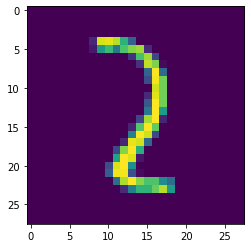

output: 2


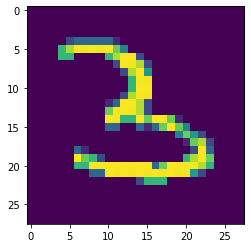

output: 3


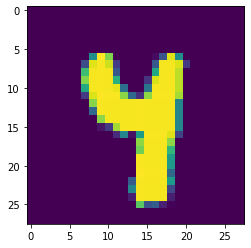

output: 4


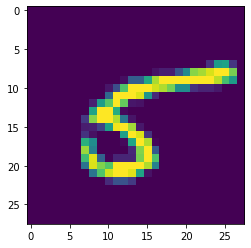

output: 5


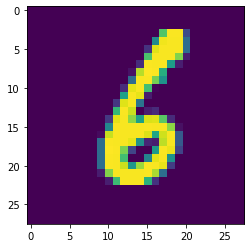

output: 6


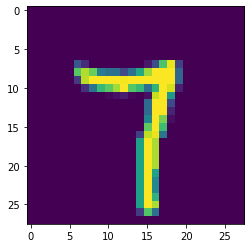

output: 7


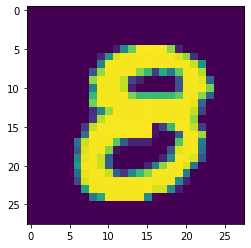

output: 8


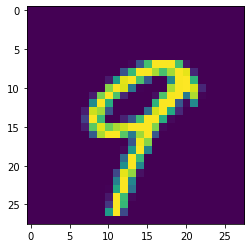

output: 9


In [6]:
model = torch.load('../model.pt')
model_inferencer = ModelV3Inferencer(model, config)

preprocessed_data = model_inferencer.load_and_preprocess_data('../mnist_inputs.npy')
output_data = model_inferencer.inference(preprocessed_data)

for in_d, out_d in zip(preprocessed_data.numpy(), output_data.numpy()):
    plt.imshow(in_d[0])
    plt.show()
    print('output:', out_d)